In [150]:
from __future__ import print_function
import keras
import numpy as np
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import matplotlib.pylab as plt
import json

In [151]:
batch_size = 10
epochs = 100
channels = 5
grid_width, grid_height = 10, 10

In [152]:
input_data = json.load(open('../data/citywars.log'))

In [153]:
multi_channel_input_data = np.asarray([np.stack([
    np.asarray(sample['cities']).reshape(grid_width, grid_height),
    np.asarray(sample['player0']).reshape(grid_width, grid_height),
    np.asarray(sample['player1']).reshape(grid_width, grid_height),
    np.asarray(sample['obstacles']).reshape(grid_width, grid_height),
    np.asarray(sample['trajectory']).reshape(grid_width, grid_height)
], axis=-1) for sample in input_data])

labels = [sample['arrival'] for sample in input_data]

In [154]:
x_train = np.asarray([multi_channel_input_data[0] for x in range(1000)])
x_test = np.asarray([multi_channel_input_data[0] for x in range(100)])

y_train = np.asarray([labels[0] for x in range(1000)])
y_test = np.asarray([labels[0] for x in range(100)])

In [155]:
input_shape = (grid_width, grid_height, channels)

x_train shape: (1000, 10, 10, 5)
1000 train samples
100 test samples
Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 2s 3ms/step - loss: 8.6161e-04 - mean_absolute_error: 0.0139 - val_loss: 4.2127e-08 - val_mean_absolute_error: 2.0525e-04
Epoch 2/100
800/800 [==============================] - 0s 201us/step - loss: 1.4407e-06 - mean_absolute_error: 9.7449e-04 - val_loss: 5.1522e-07 - val_mean_absolute_error: 7.1779e-04
Epoch 3/100
800/800 [==============================] - 0s 219us/step - loss: 1.0287e-07 - mean_absolute_error: 2.7059e-04 - val_loss: 2.8043e-08 - val_mean_absolute_error: 1.6746e-04
Epoch 4/100
800/800 [==============================] - 0s 229us/step - loss: 7.1521e-09 - mean_absolute_error: 7.1726e-05 - val_loss: 1.2096e-09 - val_mean_absolute_error: 3.4779e-05
Epoch 5/100
800/800 [==============================] - 0s 237us/step - loss: 5.9972e-10 - mean_absolute_error: 2.0821e-05 - val_loss: 4.1056e-11 - val_mean_abs

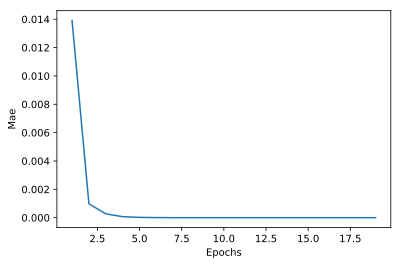

In [156]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mae'])


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.mae = []

    def on_epoch_end(self, batch, logs={}):
        self.mae.append(logs.get('mean_absolute_error'))


history = AccuracyHistory()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.fit(x_train, y_train,
          epochs=epochs,
          verbose=1,
          validation_split=0.2,
          callbacks=[history, es])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mae:', score[1])
plt.plot(range(1, len(history.mae)+1), history.mae)
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.show()